In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import clip
from torch.nn import functional as F
import torch.nn as nn
from torchvision import transforms
from PIL import Image
train = False
classes = None
pictures= None

def load_data():
    data_list = []
    label_list = []
    texts = []
    images = []
    
    if train:
        text_directory = "/home/ldy/Workspace/THINGS/images_set/training_images"  
    else:
        text_directory = "/home/ldy/Workspace/THINGS/images_set/test_images"
    dirnames = [d for d in os.listdir(text_directory) if os.path.isdir(os.path.join(text_directory, d))]
    dirnames.sort()
    
    if classes is not None:
        dirnames = [dirnames[i] for i in classes]

    for dir in dirnames:
        try:
            idx = dir.index('_')
        except ValueError:
            print(f"Skipped: {dir} due to no '_' found.")
            continue
            
        new_description = f"{description}"
        texts.append(new_description)

    if train:
    else:
        img_directory ="/home/ldy/Workspace/THINGS/images_set/test_images"
    
    all_folders = [d for d in os.listdir(img_directory) if os.path.isdir(os.path.join(img_directory, d))]

    if classes is not None and pictures is not None:
        for i in range(len(classes)):
            class_idx = classes[i]
            pic_idx = pictures[i]
            if class_idx < len(all_folders):
                folder = all_folders[class_idx]
                folder_path = os.path.join(img_directory, folder)
                all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_images.sort()
                if pic_idx < len(all_images):
                    images.append(os.path.join(folder_path, all_images[pic_idx]))
    elif classes is not None and pictures is None:
        for i in range(len(classes)):
            class_idx = classes[i]
            if class_idx < len(all_folders):
                folder = all_folders[class_idx]
                folder_path = os.path.join(img_directory, folder)
                all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_images.sort()
                images.extend(os.path.join(folder_path, img) for img in all_images)
    elif classes is None:
        for folder in all_folders:
            folder_path = os.path.join(img_directory, folder)
            all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            all_images.sort()  
            images.extend(os.path.join(folder_path, img) for img in all_images)
    else:
        print("Error")
    return texts, images
texts, images = load_data()
# images

Data tensor shape: torch.Size([200, 17, 100]), label tensor shape: torch.Size([200]), text length: 200, image length: 200
extracted_data shape: torch.Size([200, 17, 80])
number of parameters: 1378564
logits_single torch.Size([200, 200])
similarity_matrix_np torch.Size([200, 200])


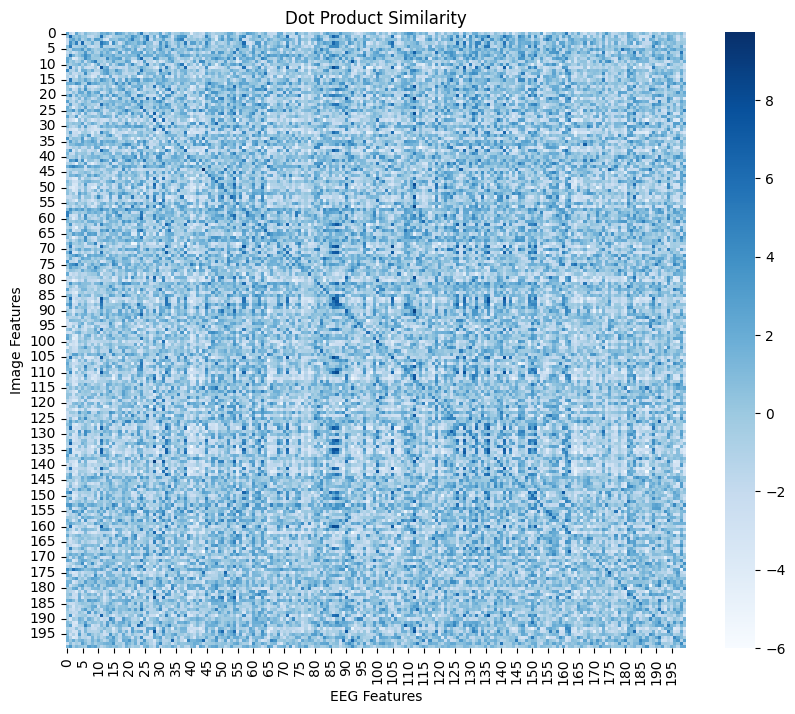

 - Test Loss: 6.8372, Test Accuracy: 0.1500


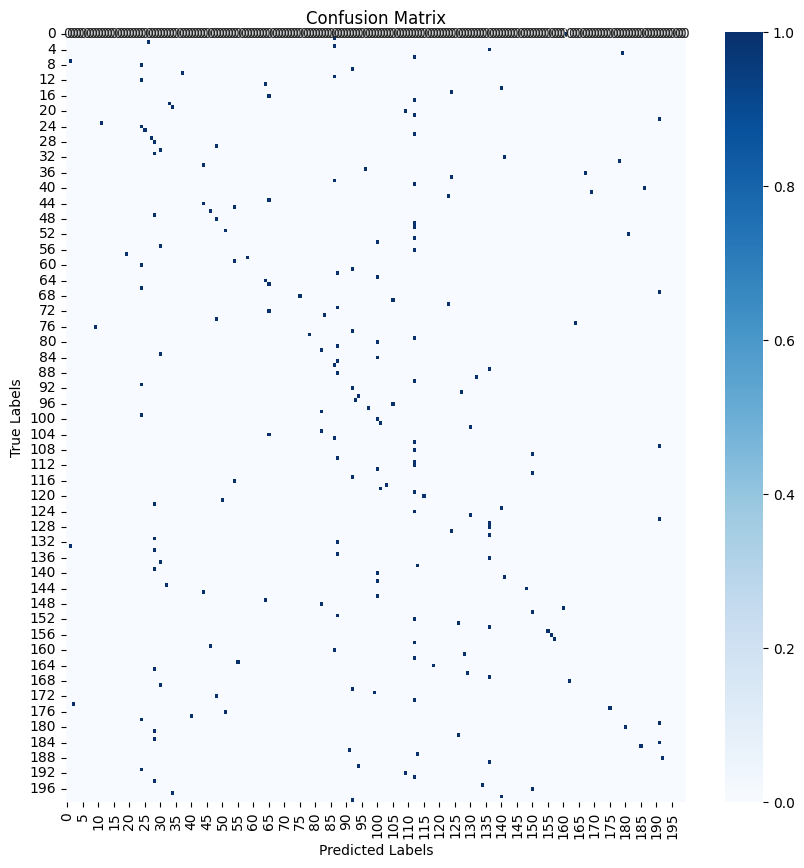

In [57]:
import os

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ["WANDB_API_KEY"] = "KEY"
os.environ["WANDB_MODE"] = 'offline'
from itertools import combinations

import clip
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import tqdm
from new_cls_eegdatasets import EEGDataset
from eegencoder import eeg_encoder
from einops.layers.torch import Rearrange, Reduce
from lavis.models.clip_models.loss import ClipLoss
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
import random
from utils import wandb_logger

def make_block(h_c, h_l,dropout_rate=0.25):
    block = nn.Sequential(
        nn.LayerNorm(h_l),
        nn.Linear(h_l, h_l), 
        nn.GELU(),
        nn.Dropout(dropout_rate),  
        Rearrange('B C L->B L C'),
        nn.LayerNorm(h_c),
        nn.Linear(h_c, h_c), 
        nn.GELU(),
        nn.Dropout(dropout_rate),  
        Rearrange('B L C->B C L'),
    )
    return block

class Projector(nn.Module):

    def __init__(self, in_features, h_dim=(64, 512), n_hidden_layer=4,dropout_rate=0.25):
        # in_features: (c, l)
        super().__init__()
        c, l = in_features
        h_c, h_l = h_dim
        c_o, l_o = 1, 512

        self.input_layer = nn.Sequential(
            nn.LayerNorm(l),
            nn.Linear(l, h_l), 
            nn.GELU(),
            nn.Dropout(dropout_rate),  
            Rearrange('B C L->B L C'),
            nn.LayerNorm(c),
            nn.Linear(c, h_c), 
            nn.GELU(),
            nn.Dropout(dropout_rate),  
            Rearrange('B L C->B C L'),
        )
        
        self.output_layer = nn.Sequential(
            nn.LayerNorm(h_l),
            nn.Linear(h_l, l_o), 
            nn.GELU(),
            nn.Dropout(dropout_rate),  
            Rearrange('B C L->B L C'),
            nn.LayerNorm(h_c),
            nn.Linear(h_c, c_o), 
            nn.GELU(),
            nn.Dropout(dropout_rate),  
            Rearrange('B L C->B (C L)'),
        )
        
        self.blocks = nn.Sequential(*[
            make_block(h_c, h_l) for _ in range(n_hidden_layer)
        ])
        
        self.projector = nn.Sequential(*[
            self.input_layer,
            self.blocks,
            self.output_layer,
        ])

        # self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1/0.01))
                
        self.loss_func = ClipLoss()
    
    def forward(self, eeg_embeds):
        
        eeg_embeds = self.projector(eeg_embeds)
        # print("eeg_embeds")
        # print(eeg_embeds.shape)
        eeg_features = F.normalize(eeg_embeds, dim=-1)
        return eeg_features



import seaborn as sns

def get_eegfeatures(model, dataloader, device, text_features_all, img_features_all, k):
    model.eval()
    text_features_all = text_features_all.to(device).float()
    img_features_all = img_features_all.to(device).float()
    total_loss = 0
    correct = 0
    total = 0
    alpha = 0.99
    save_features = True
    features_list = []
    true_labels = []
    pred_labels = []
    eeg_features_list = []
    img_features_list = []

    all_labels = set(range(text_features_all.size(0)))
    
    with torch.no_grad():
        for batch_idx, (eeg_data, labels, text, text_features, img, img_features) in enumerate(dataloader):
            eeg_data = eeg_data.to(device)
            text_features = text_features.to(device).float()
            labels = labels.to(device)
            img_features = img_features.to(device).float()
            eeg_features = model(eeg_data).float()
            eeg_features_list.append(eeg_features)
            img_features_list.append(img_features.to(device))
            features_list.append(eeg_features)
            
            logit_scale = model.logit_scale 
            # print(eeg_features.type, text_features.type, img_features.type)
            img_loss = model.loss_func(eeg_features, img_features, logit_scale)
            text_loss = model.loss_func(eeg_features, text_features, logit_scale)
            loss = img_loss*alpha + text_loss*(1-alpha)
            total_loss += loss.item()

            
            logits_single = logit_scale * eeg_features @ img_features_all.T
            print("logits_single", logits_single.shape)
            predicted_label = torch.argmax(logits_single, dim=1)
            # predicted_label = selected_classes[torch.argmax(logits_single).item()] # (n_batch, ) \in {0, 1, ..., n_cls-1}
            
            
            correct += (predicted_label == labels).sum().item()         
            similarity_matrix_np = (logit_scale * eeg_features @ img_features_all.T).cpu()
            # similarity_matrix_np = torch.argmax(similarity_matrix_np, dim=1)
            # print(similarity_matrix_np)
            print("similarity_matrix_np", similarity_matrix_np.shape)
            # max_indices = similarity_matrix_np.argmax(axis=0)
            # zeroed_similarity_matrix = np.zeros_like(similarity_matrix_np)
            # zeroed_similarity_matrix[max_indices, np.arange(similarity_matrix_np.shape[1])] = similarity_matrix_np[max_indices, np.arange(similarity_matrix_np.shape[1])]

            plt.figure(figsize=(10, 8))
            sns.heatmap(similarity_matrix_np, cmap='Blues')  # Using a blue color scheme
            plt.title('Dot Product Similarity')
            plt.xlabel('EEG Features')
            plt.ylabel('Image Features')
            plt.show()    
        # if save_features:
        #     features_tensor = torch.cat(features_list, dim=0)
        #     torch.save(features_tensor, "eeg_features.pt")  # Save features as .pt file
        true_labels =     labels.tolist()
        pred_labels = predicted_label.tolist()
    average_loss = total_loss / (batch_idx+1)
    accuracy = correct / len(img_features_all)
    eeg_features_all = torch.cat(eeg_features_list, dim=0)
    img_features_all = torch.cat(img_features_list, dim=0)
    
    return average_loss, accuracy, true_labels, pred_labels, eeg_features_all, img_features_all

config = {
"data_path": "/home/ldy/Workspace/THINGS/EEG/osfstorage-archive",
"project": "train_pos_img_text_rep",
"entity": "sustech_rethinkingbci",
"name": "lr=3e-4_img_pos_pro_eeg",
"lr": 3e-4,
"epochs": 50,
"batch_size": 16,
"logger": True
}

# with open('config.json', 'r') as f:
#     config = json.load(f)

data_path = config['data_path']
test_dataset = EEGDataset(data_path, subjects = ['sub-01'],train=False)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False, num_workers=0, drop_last=True)

text_features_test_all = test_dataset.text_features
img_features_test_all = test_dataset.img_features


model = Projector(in_features)
print('number of parameters:', sum([p.numel() for p in model.parameters()]))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.load_state_dict(torch.load("/home/ldy/Workspace/BrainAligning/models/sub-01_35.pth"))
# ... existing code to evaluate the model ...

test_loss, test_accuracy, true_labels, pred_labels,eeg_features_all, img_features_all = get_eegfeatures(model, test_loader, device, text_features_test_all, img_features_test_all, k=200)
print(f" - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
import seaborn as sns
# Plotting the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

    

In [21]:
# if classes is None and pictures is None:
#     features_filename = os.path.join('/home/ldy/Workspace/THINGS/CLIP', 'features_train.pt') if train else os.path.join('/home/ldy/Workspace/THINGS/CLIP', 'features_test.pt')
    
#     if os.path.exists(features_filename) :
#         saved_features = torch.load(features_filename)
#         text_features = saved_features['text_features']
#         img_features = saved_features['img_features']
# eeg_features = torch.load("eeg_features.pt")
eeg_features = eeg_features_all
img_features = img_features_all

img_features.shape
# text_features.shape
eeg_features.shape

torch.Size([200, 512])

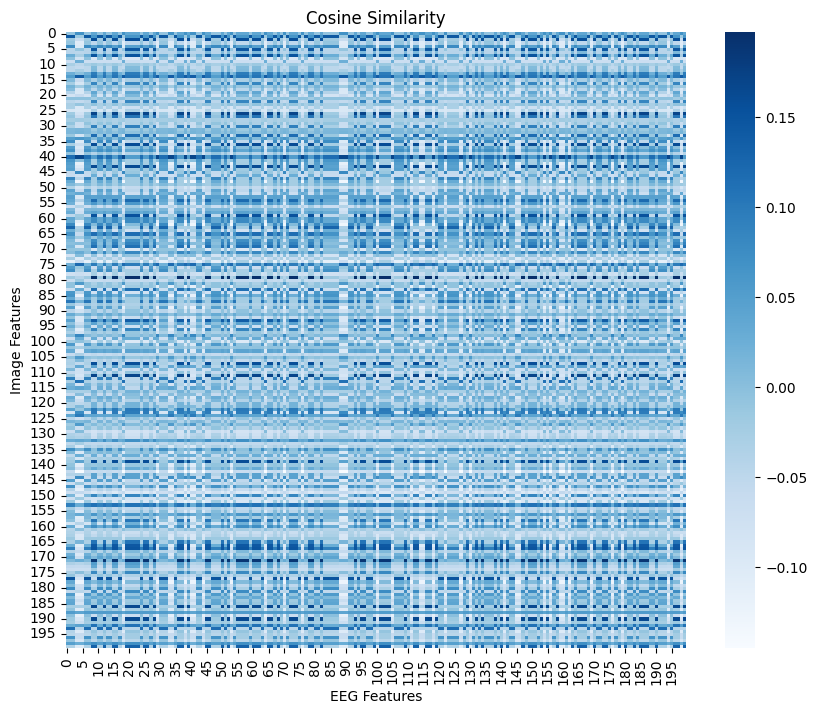

In [19]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


# Function to calculate cosine similarity in batches
def batch_cosine_similarity(features1, features2, batch_size=50):
    n1 = features1.shape[0]
    n2 = features2.shape[0]
    similarity_matrix = torch.zeros((n1, n2))

    for start1 in range(0, n1, batch_size):
        end1 = min(start1 + batch_size, n1)
        batch1 = features1[start1:end1]

        for start2 in range(0, n2, batch_size):
            end2 = min(start2 + batch_size, n2)
            batch2 = features2[start2:end2]

            sim = torch.nn.functional.cosine_similarity(batch1[:, None, :], batch2[None, :, :], dim=2)
            similarity_matrix[start1:end1, start2:end2] = sim

    return similarity_matrix
# img_features = eeg_features
img_features = img_features[:].float()
eeg_features = eeg_features[:].float()
# Assuming you have a similarity matrix calculated using batch_cosine_similarity
similarity_matrix = batch_cosine_similarity(eeg_features, img_features)


# import numpy as np
# from sklearn.cluster import KMeans
# logits = eeg_features @ img_features.T
# kmeans_text = KMeans(n_clusters=5)
# logits_np = logits.cpu().numpy()
# eeg_features_np = eeg_features.cpu().numpy()
# img_features_np = img_features.cpu().numpy()

# concept_labels = kmeans_text.fit_predict(logits_np)
# print("concept_labels", concept_labels)
# sorted_indices = np.argsort(concept_labels)
# sorted_similarity_matrix = similarity_matrix[sorted_indices, :]
# # print(sorted_similarity_matrix)
# sorted_similarity_matrix = sorted_similarity_matrix[:, sorted_indices]


# Plotting the cosine similarity matrix with a monochromatic color scheme
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='Blues')  # Using grayscale for monochromatic
plt.title('Cosine Similarity')
plt.xlabel('EEG Features')
plt.ylabel('Image Features')
plt.show()

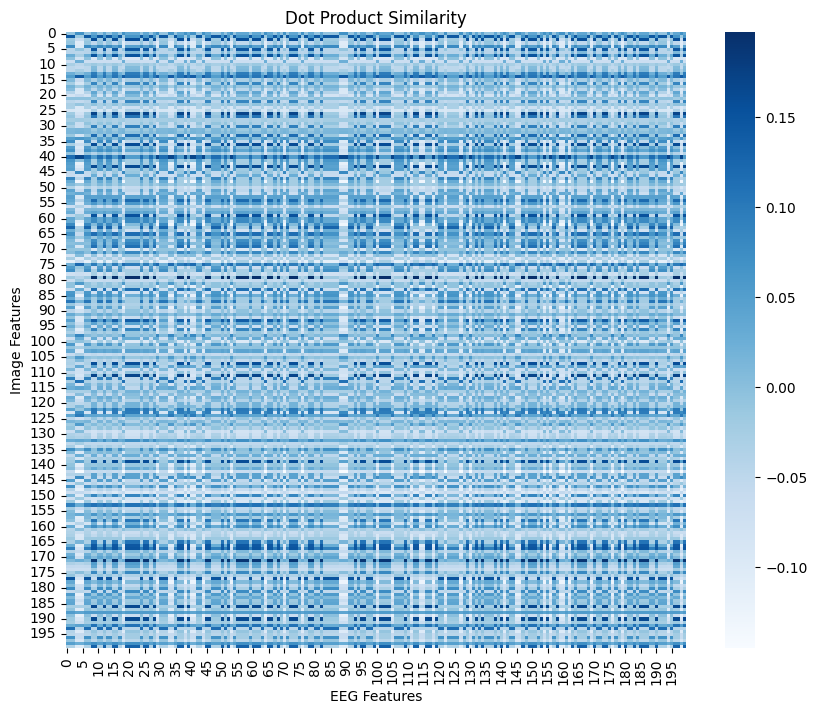

In [22]:
# Calculate similarity matrix using dot product (matrix multiplication)
similarity_matrix = eeg_features @ img_features.T

# Convert the similarity matrix from torch tensor to numpy array for plotting
similarity_matrix_np = similarity_matrix.cpu().numpy()

# Plotting the similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix_np, cmap='Blues')  # Using a blue color scheme
plt.title('Dot Product Similarity')
plt.xlabel('EEG Features')
plt.ylabel('Image Features')
plt.show()

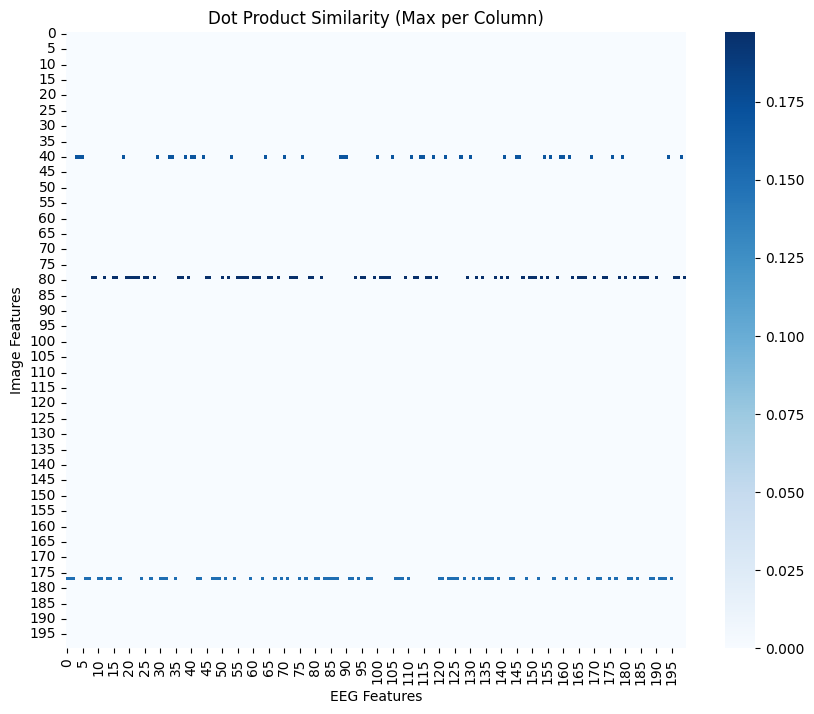

In [23]:
# Zero out all elements except for the maximum in each column
max_indices = similarity_matrix_np.argmax(axis=0)
zeroed_similarity_matrix = np.zeros_like(similarity_matrix_np)
zeroed_similarity_matrix[max_indices, np.arange(similarity_matrix_np.shape[1])] = similarity_matrix_np[max_indices, np.arange(similarity_matrix_np.shape[1])]

# Plotting the modified similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(zeroed_similarity_matrix, cmap='Blues')
plt.title('Dot Product Similarity (Max per Column)')
plt.xlabel('EEG Features')
plt.ylabel('Image Features')
plt.show()